<a href="https://colab.research.google.com/github/NamanChaudhary1/Low-Light-Image-Enhancement-Using-CNN/blob/main/NamanChaudhary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import os
import cv2 as cv
import matplotlib.pyplot as plt
from keras import backend as K
from keras.layers import add, Conv2D,MaxPooling2D,UpSampling2D,Input,BatchNormalization, RepeatVector, Reshape
from keras.models import Model
np.random.seed(2)

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [4]:
InputPath = "/content/drive/MyDrive/LOLdataset/our485/high/"

In [5]:
def noisy(noise_typ, image):
    if noise_typ == "s&p":
        row, col, ch = image.shape
        s_vs_p = 0.5
        amount = 1
        noisy_image = np.copy(image)

        # Salt mode
        num_salt = np.ceil(image.size * s_vs_p)
        salt_coords = [np.random.randint(0, i, int(num_salt)) for i in image.shape]
        noisy_image[tuple(salt_coords)] = 1

        # Pepper mode
        num_pepper = np.ceil(image.size * (1.0 - s_vs_p))
        pepper_coords = [np.random.randint(0, i, int(num_pepper)) for i in image.shape]
        noisy_image[tuple(pepper_coords)] = 1

        return noisy_image

REAL IMAGE

242

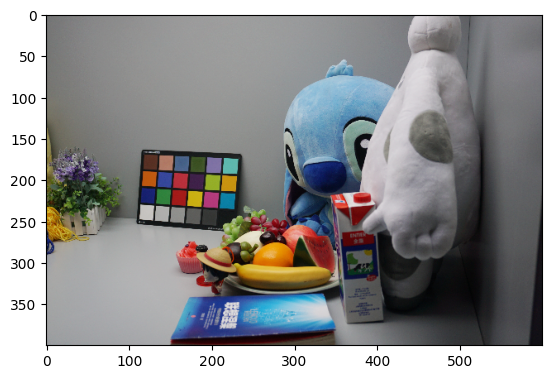

In [6]:
img = cv.imread(InputPath+"477.png")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
l = img.max()
plt.imshow(img)
l

ADD NOISE TO IT

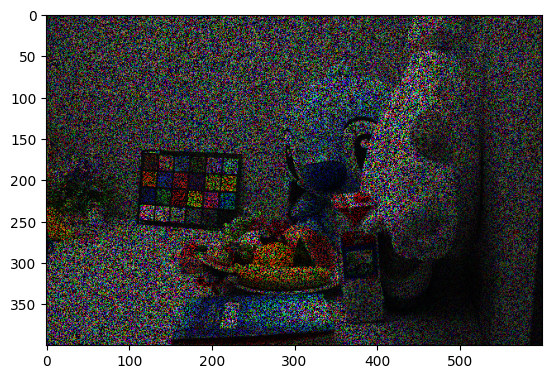

In [7]:
Noise = noisy("s&p",img)
plt.imshow(Noise)

GETTING PERFECT LOW ON LIGHT IMAGE

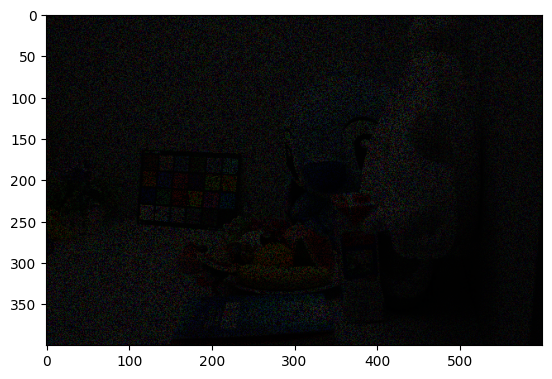

In [8]:
hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV) #convert it to hsv
hsv[...,2] = hsv[...,2]*0.2
img1 = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
Noise2 = noisy("s&p",img1)

plt.imshow(Noise2)

In [9]:
def PreProcessData(ImagePath):
    X_=[]
    y_=[]
    count=0
    for imageDir in os.listdir(ImagePath):
        if count<2131:
            try:
                count=count+1
                img = cv.imread(ImagePath + imageDir)
                img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
                img_y = cv.resize(img,(500,500))
                hsv = cv.cvtColor(img_y, cv.COLOR_BGR2HSV) #convert it to hsv
                hsv[...,2] = hsv[...,2]*0.2
                img_1 = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
                Noisey_img = noisy("s&p",img_1)
                X_.append(Noisey_img)
                y_.append(img_y)
            except:
                pass
    X_ = np.array(X_)
    y_ = np.array(y_)

    return X_,y_

In [10]:
X_,y_ = PreProcessData(InputPath)

In [11]:
K.clear_session()
def InstantiateModel(in_):

    model_1 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(in_)
    model_1 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(model_1)
    model_1 = Conv2D(64,(2,2), activation='relu',padding='same',strides=1)(model_1)

    model_2 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(in_)
    model_2 = Conv2D(64,(2,2), activation='relu',padding='same',strides=1)(model_2)

    model_2_0 = Conv2D(64,(2,2), activation='relu',padding='same',strides=1)(model_2)

    model_add = add([model_1,model_2,model_2_0])

    model_3 = Conv2D(64,(3,3), activation='relu',padding='same',strides=1)(model_add)
    model_3 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(model_3)
    model_3 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_3)

    model_3_1 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(model_add)
    model_3_1 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_3_1)

    model_3_2 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_add)

    model_add_2 = add([model_3_1,model_3_2,model_3])

    model_4 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(model_add_2)
    model_4_1 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(model_add)

    model_add_3 = add([model_4_1,model_add_2,model_4])

    model_5 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(model_add_3)
    model_5 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_add_3)

    model_5 = Conv2D(3,(3,3), activation='relu',padding='same',strides=1)(model_5)

    return model_5


In [12]:
Input_Sample = Input(shape=(500, 500,3))
Output_ = InstantiateModel(Input_Sample)
Model_Enhancer = Model(inputs=Input_Sample, outputs=Output_)
Model_Enhancer.compile(optimizer="adam", loss='mean_squared_error')
Model_Enhancer.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 500, 500, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 500, 500, 16)         448       ['input_1[0][0]']             
                                                                                                  
 conv2d_3 (Conv2D)           (None, 500, 500, 32)         896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 500, 500, 32)         4640      ['conv2d[0][0]']              
                                                                                              

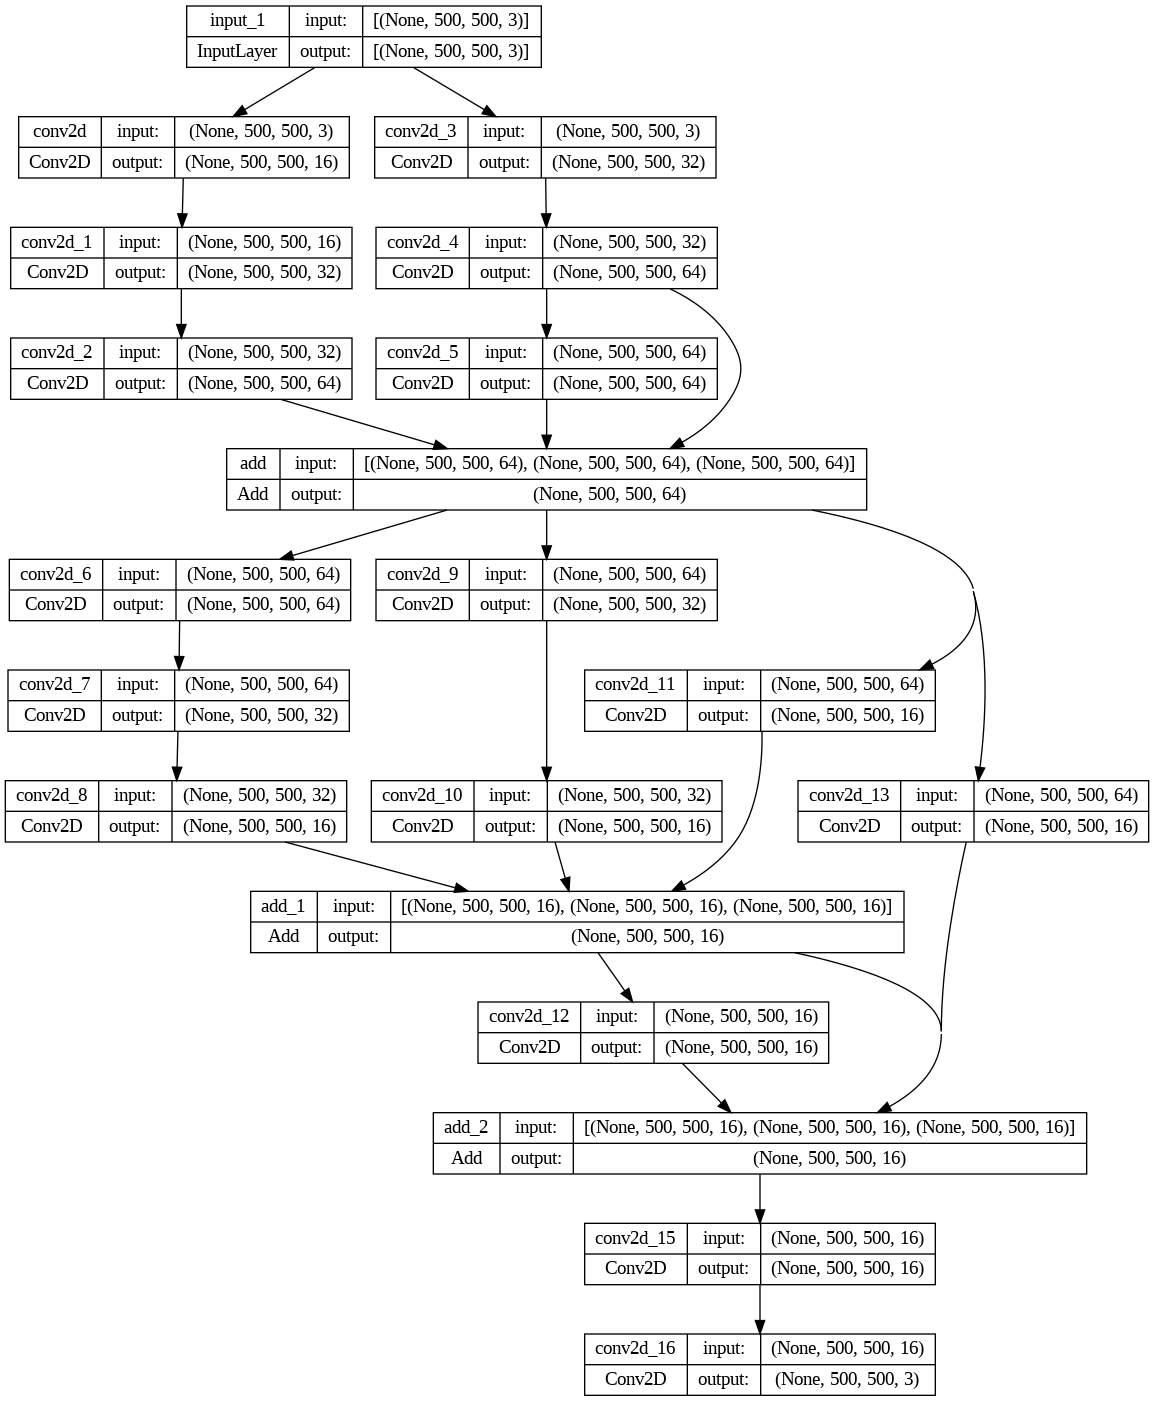

In [13]:
from tensorflow.keras.utils import plot_model
plot_model(Model_Enhancer,to_file='model_.png',show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image(retina=True, filename='model_.png')

In [14]:
def GenerateInputs(X,y):
    for i in range(len(X)):
        X_input = X[i].reshape(1,500,500,3)
        y_input = y[i].reshape(1,500,500,3)
        yield (X_input,y_input)
Model_Enhancer.fit_generator(GenerateInputs(X_,y_),epochs=53,verbose=1,steps_per_epoch=39,shuffle=True)

Epoch 1/53


<ipython-input-14-c5f0e23b4ee9>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  Model_Enhancer.fit_generator(GenerateInputs(X_,y_),epochs=53,verbose=1,steps_per_epoch=39,shuffle=True)


39/39 [==============================] - 21s 93ms/step - loss: 3053.6189
Epoch 2/53
39/39 [==============================] - 4s 93ms/step - loss: 474.2708
Epoch 3/53
39/39 [==============================] - 4s 93ms/step - loss: 397.4224
Epoch 4/53
39/39 [==============================] - 4s 93ms/step - loss: 503.5371
Epoch 5/53
39/39 [==============================] - 4s 95ms/step - loss: 392.9565
Epoch 6/53
39/39 [==============================] - 4s 93ms/step - loss: 497.7844
Epoch 7/53
39/39 [==============================] - 4s 94ms/step - loss: 363.5508
Epoch 8/53
39/39 [==============================] - 4s 95ms/step - loss: 420.5700
Epoch 9/53
39/39 [==============================] - 4s 95ms/step - loss: 362.3914
Epoch 10/53
39/39 [==============================] - 4s 95ms/step - loss: 313.3332
Epoch 11/53
39/39 [==============================] - 4s 95ms/step - loss: 254.4984
Epoch 12/53
39/39 [==============================] - 4s 96ms/step - loss: 194.1275
Epoch 13/53
17/39 [===

39/39 [==============================] - 2s 48ms/step - loss: 255.8350


In [23]:
TestPath="/content/drive/MyDrive/LOLdataset/our485/high/"

In [16]:
def ExtractTestInput(ImagePath):
    img = cv.imread(ImagePath)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img_ = cv.resize(img,(500,500))
    hsv = cv.cvtColor(img_, cv.COLOR_BGR2HSV) #convert it to hsv
    hsv[...,2] = hsv[...,2]*0.2
    img1 = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
    Noise = noisy("s&p",img1)
    Noise = Noise.reshape(1,500,500,3)
    return Noise

1/1 [==============================] - 0s 28ms/step


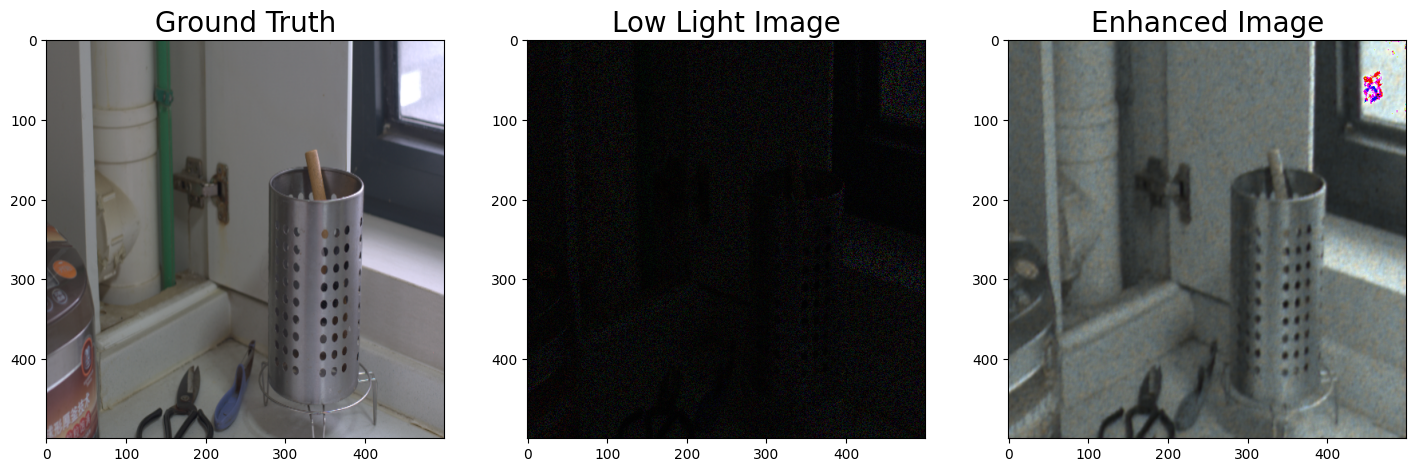

In [35]:
ImagePath=TestPath+"112.png"
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
img_1 = cv.imread(ImagePath)
img_1 = cv.cvtColor(img_1, cv.COLOR_BGR2RGB)
img_1 = cv.resize(img_1, (500, 500))
plt.title("Ground Truth",fontsize=20)
plt.imshow(img_1)

plt.subplot(5,5,1+1)
img_ = ExtractTestInput(ImagePath)
img_ = img_.reshape(500,500,3)
plt.title("Low Light Image",fontsize=20)
plt.imshow(img_)

plt.subplot(5,5,1+2)
image_for_test = ExtractTestInput(ImagePath)
Prediction = Model_Enhancer.predict(image_for_test)
Prediction = Prediction.reshape(500,500,3)
img_[:,:,:] = Prediction[:,:,:]
plt.title("Enhanced Image",fontsize=20)
plt.imshow(img_)